### Блок 1: Обработка входных данных

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Проверяем доступные устройства CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создание класса для вашего Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = {'x': self.x[idx], 'y': self.y[idx]}
        return sample

# Загрузка данных из файлов .npy
y_smp_train = np.load('y_smp_train.npy')
pars_smp_train = np.load('pars_smp_train.npy')

# # Разделение данных на тренировочные и тестовые выборки
# X_train, X_test, y_train, y_test = train_test_split(y_smp_train, pars_smp_train, test_size=0.2, random_state=42)

# # Преобразование данных в тензоры PyTorch и перемещение на GPU
# X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

# X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_smp_train = torch.tensor(y_smp_train, dtype=torch.float32).to(device)
pars_smp_train = torch.tensor(pars_smp_train, dtype=torch.float32).to(device)

pars_smp_train = pars_smp_train.reshape(pars_smp_train.shape[0], -1)

# Создание экземпляра CustomDataset для тренировочных и тестовых данных
# train_dataset = CustomDataset(X_train, y_train)
# test_dataset = CustomDataset(X_test, y_test)
full_dataset = CustomDataset(y_smp_train, pars_smp_train)

# Создание DataLoader для тренировочных и тестовых данных
batch_size = 512
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)
full_loader = DataLoader(full_dataset, batch_size=batch_size)

### Блок 2: Нейронные сети

In [2]:
class MainModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super(MainModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.conv1d = nn.Conv1d(hidden_size, 64, kernel_size=3, padding=1)
        self.maxpool1d = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(6400, 128)
        self.batchnorm = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(dropout_prob)
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        
        # Применение сверточных и пулинг слоев
        out = out.permute(0, 2, 1)  # Изменение порядка размерностей для свертки
        out = self.conv1d(out)
        out = self.maxpool1d(out)
        out = out.view(out.size(0), -1)  # Разворачивание для полносвязных слоев
        
        out = self.fc1(out)
        out = self.batchnorm(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    def get_embeddings(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        
        # Получение эмбеддингов после последних линейных слоев
        out = out.permute(0, 2, 1)  # Изменение порядка размерностей для свертки
        out = self.conv1d(out)
        out = self.maxpool1d(out)
        out = out.view(out.size(0), -1)  # Разворачивание для полносвязных слоев
        embeddings = self.fc1(out)

        return embeddings

In [3]:
# class CMPModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
#         super(CMPModel, self).__init__()
#         self.num_layers = num_layers
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
#         self.fc1 = nn.Linear(hidden_size, 128)
#         self.fc2 = nn.Linear(128, output_size)
#         self.dropout = nn.Dropout(dropout_prob)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = out[:, -1, :]  # Последний выход LSTM
#         out = self.fc1(out)
#         out = torch.relu(out)
#         out = self.dropout(out)
#         out = self.fc2(out)
#         return out


In [4]:
# class ImprovedLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
#         super(ImprovedLSTMModel, self).__init__()
#         self.num_layers = num_layers
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
#         self.fc1 = nn.Linear(hidden_size, 128)
#         self.batchnorm = nn.BatchNorm1d(128)  # Добавлен слой батч-нормализации
#         self.fc2 = nn.Linear(128, output_size)
#         self.dropout = nn.Dropout(dropout_prob)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
        
#         # Получение эмбеддингов после LSTM
#         embeddings = out[:, -1, :]  # Последний выход LSTM
        
#         out = self.fc1(embeddings)
#         out = self.batchnorm(out)  # Применение батч-нормализации
#         out = torch.relu(out)
#         out = self.dropout(out)
#         out = self.fc2(out)
#         return out

#     def get_embeddings(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
        
#         # Получение эмбеддингов после LSTM
#         embeddings = out[:, -1, :]  # Последний выход LSTM
#         return embeddings

In [5]:
# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
#         super(ComplexLSTMModel, self).__init__()
#         self.num_layers = num_layers
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
#         self.conv1d = nn.Conv1d(hidden_size, 64, kernel_size=3, padding=1)
#         self.maxpool1d = nn.MaxPool1d(kernel_size=2)
#         self.fc1 = nn.Linear(6400, 128)
#         self.batchnorm = nn.BatchNorm1d(128)
#         self.fc2 = nn.Linear(128, output_size)
#         self.dropout = nn.Dropout(dropout_prob)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
        
#         # Применение сверточных и пулинг слоев
#         out = out.permute(0, 2, 1)  # Изменение порядка размерностей для свертки
#         out = self.conv1d(out)
#         out = self.maxpool1d(out)
#         out = out.view(out.size(0), -1)  # Разворачивание для полносвязных слоев
        
#         out = self.fc1(out)
#         out = self.batchnorm(out)
#         out = torch.relu(out)
#         out = self.dropout(out)
#         out = self.fc2(out)
        
#         return out

In [6]:
# class EnhancedGRUModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_p=0.2):
#         super(EnhancedGRUModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 64)  # Added linear layer
#         self.bn1 = nn.BatchNorm1d(64)  # Added batch normalization
#         self.dropout = nn.Dropout(p=dropout_p)  # Added dropout layer
#         self.fc2 = nn.Linear(64, output_size)
    
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         out, _ = self.gru(x, h0)
#         out = F.relu(self.fc1(out[:, -1, :]))  # Apply activation function
#         out = self.bn1(out)
#         out = self.dropout(out)
#         out = self.fc2(out)
#         return out

In [7]:
# # Define the GRU model
# class GRUModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_p=0.2):
#         super(GRUModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 128)  # Added linear layer
#         self.bn1 = nn.BatchNorm1d(128)  # Added batch normalization
#         self.dropout = nn.Dropout(p=dropout_p)  # Added dropout layer
#         self.fc2 = nn.Linear(128, output_size)
    
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         out, _ = self.gru(x, h0)
#         out = F.relu(self.fc1(out[:, -1, :]))  # Apply activation function
#         out = self.bn1(out)
#         out = self.dropout(out)
#         out = self.fc2(out)
#         return out

### Блок 3: Тренировка моделей

In [8]:
# Функция обучения модели с записью потерь
def train_model(model, train_loader, criterion, optimizer, num_epochs, scheduler):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_losses = []
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):  # Используем tqdm
            input_data, target_data = batch['x'], batch['y'].reshape(batch['y'].shape[0], 15)
            output = model(input_data)
            loss = criterion(output, target_data)
            loss = torch.sqrt(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        scheduler.step()
        # Отображение графика потерь после каждого батча
        plt.plot(epoch_losses)
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Training Loss for Batch')
        plt.show()

        train_losses.extend(epoch_losses)

    return train_losses

In [ ]:
# Параметры модели
input_size = 3
hidden_size = 256
num_layers = 3
output_size = 15

# Определение модели
model = MainModel(input_size, hidden_size, num_layers, output_size).to(device)

# Определение функции потери
criterion = nn.MSELoss()  # Используем RMSE как функцию потери

# Определение оптимизатора
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
# Обучение модели
num_epochs = 10
train_losses = train_model(model, full_loader, criterion, optimizer, num_epochs, scheduler)

In [ ]:
# Получите эмбеддинги из x и преобразуйте их в массив NumPy
embeddings_list = []
target_list = []

for batch in full_loader:
    input_data, target_data = batch['x'], batch['y']
    embeddings = model.get_embeddings(input_data).cpu()  # Перенос на CPU и получение эмбеддингов
    embeddings_list.append(embeddings.detach().numpy())
    target_list.append(target_data.cpu().numpy())  # Перенос на CPU и преобразование в NumPy

# Объедините полученные эмбеддинги и целевые значения в массивы NumPy
embeddings_array = np.concatenate(embeddings_list, axis=0)
target_array = np.concatenate(target_list, axis=0)

In [ ]:
# Разделите данные на тренировочную и тестовую выборки


# X_train, X_test, y_train, y_test = train_test_split(embeddings_array, target_array, test_size=0.2, random_state=42)

In [ ]:
# y_train = y_train.reshape(y_train.shape[0], 15)
# y_test = y_test.reshape(y_test.shape[0], 15)

In [ ]:
# Создайте экземпляр CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=2000, depth=7, learning_rate=0.22, task_type="GPU",  devices='0:1',  loss_function='MultiRMSE', custom_metric=['MultiRMSE'], random_state=42)

catboost_model.fit(embeddings_array, target_array)
# Обучите CatBoost на эмбеддингах с метрикой RMSE
# catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

In [ ]:
y_pred = catboost_model.predict(X_test)

# Вычислите RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

In [ ]:
X_test_main = np.load('y_smp_test.npy')
X_test_main = torch.tensor(X_test_main, dtype=torch.float32).to(device)

In [9]:
# Создание класса для вашего Dataset
class TestEmbedsDataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = {'x': self.x[idx]}
        return sample

In [ ]:
test_main_dataset = TestEmbedsDataset(X_test_main)
test_main_dataset_loader = DataLoader(test_main_dataset, batch_size=batch_size)
# Получите эмбеддинги из x и преобразуйте их в массив NumPy
embeddings_test_main = []

for batch in test_main_dataset_loader:
    input_data = batch['x']
    embeddings = model.get_embeddings(input_data).cpu()  # Перенос на CPU и получение эмбеддингов
    embeddings_test_main.append(embeddings.detach().numpy())

# Объедините полученные эмбеддинги и целевые значения в массивы NumPy
embeddings_test_main_array = np.concatenate(embeddings_test_main, axis=0)

In [ ]:
# predictions = catboost_model.predict(embeddings_test_main_array)

In [ ]:
# np.save('mean_predictions_main_model_128_10_epoch.npy', predictions)

In [ ]:
# Тестирование модели на тестовых данных на GPU
model.eval()
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_data, target_data = batch['x'].to(device), batch['y'].to(device).squeeze()
        input_data = input_data.to(torch.float32)  # Преобразовать в тип Float перед передачей в LSTM
        test_output = model(input_data)
        
        # Вычисление RMSE
        mse_loss = criterion(test_output, target_data)
        rmse_loss = torch.sqrt(mse_loss)
        test_losses.append(rmse_loss.item())

# Вывод результатов
avg_test_rmse = sum(test_losses) / len(test_losses)
print('Test RMSE:', avg_test_rmse)

# Отображение графиков RMSE
plt.figure(figsize=(12, 6))
plt.plot(test_losses, label='Test RMSE')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.legend()
plt.show()


### Блок: Квантили

In [10]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile=0.5):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile

    def forward(self, prediction, target):
        residual = target - prediction
        quantile_loss = torch.max((self.quantile - 1) * residual, self.quantile * residual)
        return torch.mean(quantile_loss)


0.5


Epoch 1/3: 100%|██████████| 1954/1954 [01:43<00:00, 18.86it/s]


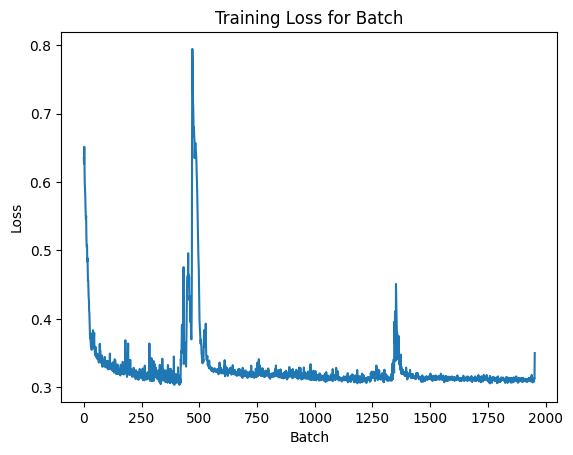

Epoch 2/3: 100%|██████████| 1954/1954 [01:42<00:00, 19.03it/s]


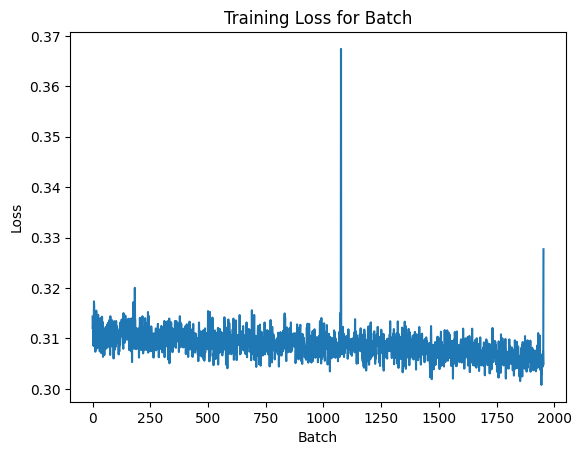

Epoch 3/3: 100%|██████████| 1954/1954 [01:42<00:00, 19.09it/s]


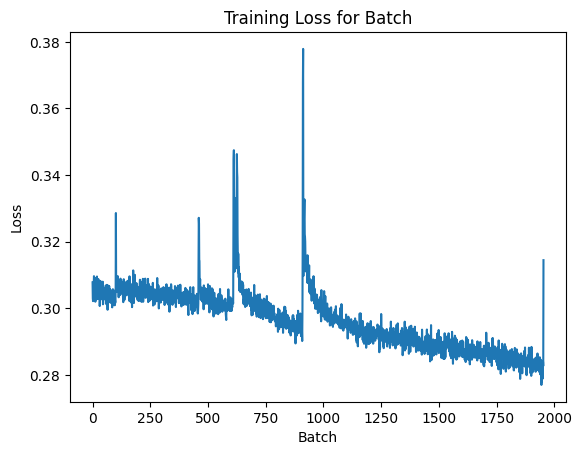

0:	learn: 1.1745964	total: 186ms	remaining: 2m 28s
1:	learn: 1.1300562	total: 306ms	remaining: 2m 2s
2:	learn: 1.0984265	total: 399ms	remaining: 1m 45s
3:	learn: 1.0766866	total: 487ms	remaining: 1m 36s
4:	learn: 1.0607975	total: 552ms	remaining: 1m 27s
5:	learn: 1.0497643	total: 599ms	remaining: 1m 19s
6:	learn: 1.0416864	total: 650ms	remaining: 1m 13s
7:	learn: 1.0356989	total: 697ms	remaining: 1m 9s
8:	learn: 1.0308508	total: 750ms	remaining: 1m 5s
9:	learn: 1.0272741	total: 798ms	remaining: 1m 3s
10:	learn: 1.0244207	total: 850ms	remaining: 1m
11:	learn: 1.0219424	total: 900ms	remaining: 59.1s
12:	learn: 1.0199468	total: 942ms	remaining: 57s
13:	learn: 1.0183325	total: 983ms	remaining: 55.2s
14:	learn: 1.0168299	total: 1.03s	remaining: 53.9s
15:	learn: 1.0154412	total: 1.07s	remaining: 52.7s
16:	learn: 1.0142124	total: 1.12s	remaining: 51.8s
17:	learn: 1.0131060	total: 1.17s	remaining: 50.7s
18:	learn: 1.0120702	total: 1.21s	remaining: 49.9s
19:	learn: 1.0112864	total: 1.25s	remain

Epoch 1/3: 100%|██████████| 1954/1954 [01:46<00:00, 18.33it/s]


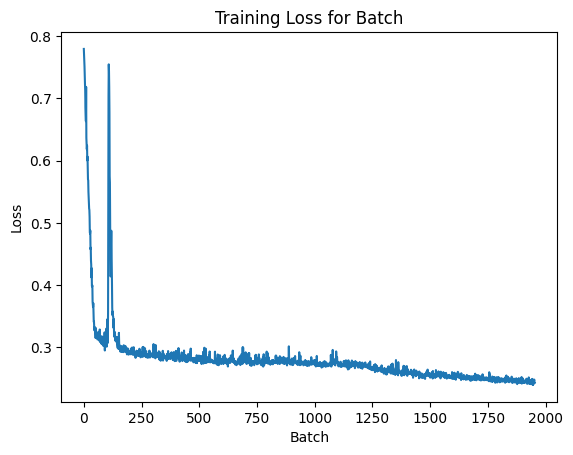

Epoch 2/3: 100%|██████████| 1954/1954 [01:59<00:00, 16.34it/s]


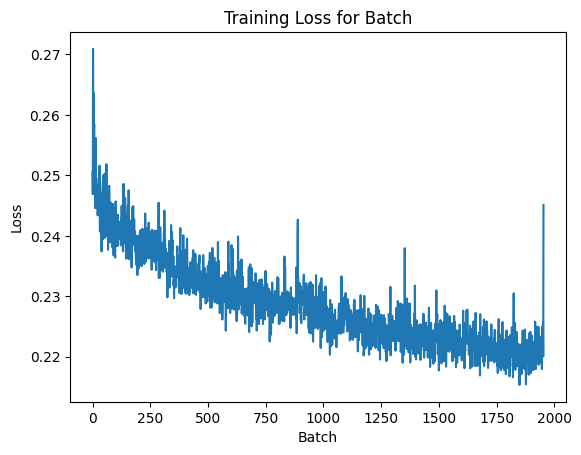

Epoch 3/3: 100%|██████████| 1954/1954 [01:43<00:00, 18.89it/s]


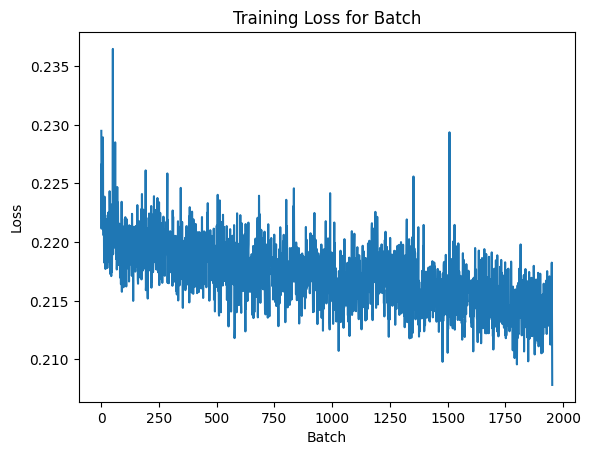

0:	learn: 1.1432783	total: 1.27s	remaining: 16m 57s
1:	learn: 1.0698248	total: 2.47s	remaining: 16m 25s
2:	learn: 1.0159778	total: 3.77s	remaining: 16m 42s
3:	learn: 0.9731622	total: 4.95s	remaining: 16m 25s
4:	learn: 0.9395518	total: 6.25s	remaining: 16m 33s
5:	learn: 0.9136986	total: 7.41s	remaining: 16m 20s
6:	learn: 0.8929476	total: 8.56s	remaining: 16m 10s
7:	learn: 0.8761871	total: 9.68s	remaining: 15m 58s
8:	learn: 0.8622585	total: 10.7s	remaining: 15m 36s
9:	learn: 0.8512278	total: 11.6s	remaining: 15m 15s
10:	learn: 0.8414041	total: 12.5s	remaining: 14m 55s
11:	learn: 0.8331340	total: 13.4s	remaining: 14m 42s
12:	learn: 0.8261775	total: 14.5s	remaining: 14m 39s
13:	learn: 0.8202166	total: 15.4s	remaining: 14m 25s
14:	learn: 0.8150694	total: 16.2s	remaining: 14m 10s
15:	learn: 0.8104842	total: 17.2s	remaining: 14m 1s
16:	learn: 0.8064602	total: 18.2s	remaining: 13m 56s
17:	learn: 0.8028263	total: 19.1s	remaining: 13m 51s
18:	learn: 0.7997939	total: 19.9s	remaining: 13m 39s
19:	

Epoch 1/3: 100%|██████████| 1954/1954 [01:57<00:00, 16.69it/s]


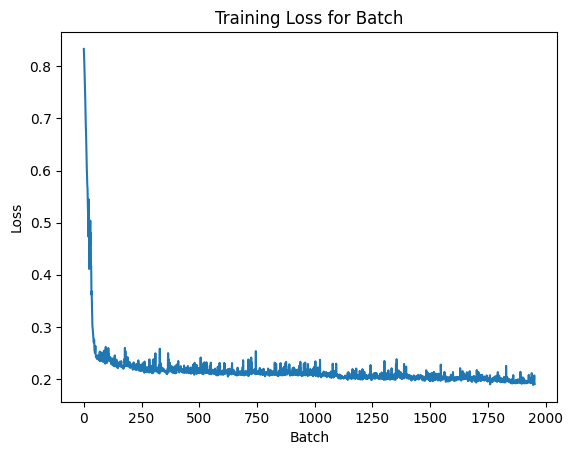

Epoch 2/3: 100%|██████████| 1954/1954 [02:03<00:00, 15.83it/s]


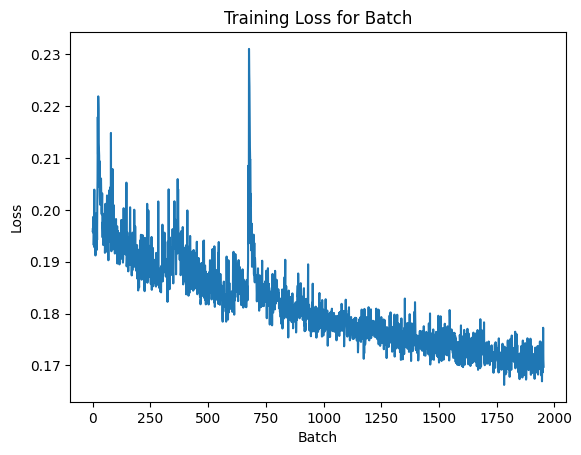

Epoch 3/3: 100%|██████████| 1954/1954 [01:59<00:00, 16.33it/s]


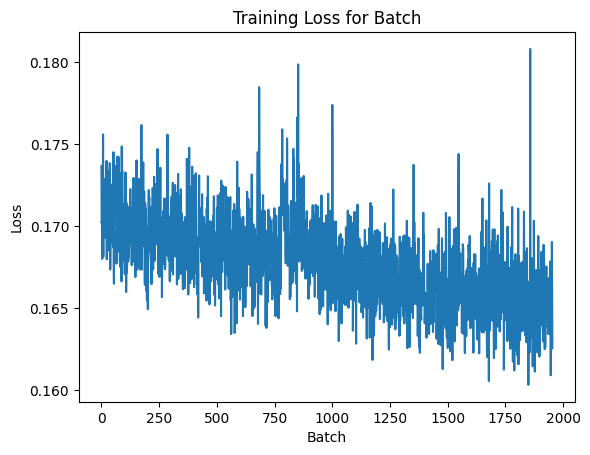

0:	learn: 1.1461592	total: 1.35s	remaining: 18m 1s
1:	learn: 1.0749217	total: 2.69s	remaining: 17m 53s
2:	learn: 1.0216511	total: 3.92s	remaining: 17m 21s
3:	learn: 0.9800044	total: 5.16s	remaining: 17m 5s
4:	learn: 0.9472875	total: 6.25s	remaining: 16m 34s
5:	learn: 0.9224208	total: 7.44s	remaining: 16m 24s
6:	learn: 0.9033805	total: 8.57s	remaining: 16m 10s
7:	learn: 0.8874345	total: 9.62s	remaining: 15m 52s
8:	learn: 0.8737346	total: 10.8s	remaining: 15m 51s
9:	learn: 0.8628813	total: 12s	remaining: 15m 48s
10:	learn: 0.8537032	total: 12.9s	remaining: 15m 27s
11:	learn: 0.8461778	total: 13.9s	remaining: 15m 16s
12:	learn: 0.8397440	total: 14.9s	remaining: 14m 59s
13:	learn: 0.8341340	total: 15.8s	remaining: 14m 44s
14:	learn: 0.8294170	total: 16.6s	remaining: 14m 28s
15:	learn: 0.8251787	total: 17.5s	remaining: 14m 17s
16:	learn: 0.8215674	total: 18.3s	remaining: 14m 4s
17:	learn: 0.8184861	total: 19.2s	remaining: 13m 55s
18:	learn: 0.8155502	total: 20.1s	remaining: 13m 46s
19:	lear

In [11]:
# Параметры модели
input_size_quantile = 3
hidden_size_quantile = 256
num_layers_quantile = 3
output_size_quantile = 15
quantile_sample_quantile = [0.50, 0.75, 0.90]
num_epochs_quantile = 3


for quantile in quantile_sample_quantile:
    criterion_quantile = QuantileLoss(quantile)
    print(quantile)
    # Определение модели
    model_quantile = MainModel(input_size_quantile, hidden_size_quantile, num_layers_quantile, output_size_quantile).to(device)

    # Определение оптимизатора
    optimizer_quantile = optim.Adam(model_quantile.parameters(), lr=0.001)

    scheduler_quantile = optim.lr_scheduler.StepLR(optimizer_quantile, step_size=10, gamma=0.5)

    # Обучение модели
    train_losses_num_epochs_quantile = train_model(model_quantile, full_loader, criterion_quantile, optimizer_quantile, num_epochs_quantile, scheduler_quantile)


    # Получите эмбеддинги из x и преобразуйте их в массив NumPy
    embeddings_list_quantile = []
    target_list_quantile = []

    for batch in full_loader:
        input_data, target_data = batch['x'], batch['y']
        embeddings = model_quantile.get_embeddings(input_data).cpu()  # Перенос на CPU и получение эмбеддингов
        embeddings_list_quantile.append(embeddings.detach().numpy())
        target_list_quantile.append(target_data.cpu().numpy())  # Перенос на CPU и преобразование в NumPy

    # Объедините полученные эмбеддинги и целевые значения в массивы NumPy
    embeddings_array_quantile = np.concatenate(embeddings_list_quantile, axis=0)
    target_array_quantile = np.concatenate(target_list_quantile, axis=0)

    # Создайте экземпляр CatBoostRegressor
    catboost_model_quantile = CatBoostRegressor(iterations=800, depth=7, learning_rate=0.22, task_type="GPU",  devices='0:1',  loss_function='MultiRMSE', custom_metric=['MultiRMSE'], random_state=42)

    catboost_model_quantile.fit(embeddings_array_quantile, target_array_quantile)

    X_test_main_quantile = np.load('y_smp_test.npy')
    X_test_main_quantile = torch.tensor(X_test_main_quantile, dtype=torch.float32).to(device)

    test_main_dataset_quantile = TestEmbedsDataset(X_test_main_quantile)
    test_main_dataset_loader_quantile = DataLoader(test_main_dataset_quantile, batch_size=batch_size)
    # Получите эмбеддинги из x и преобразуйте их в массив NumPy
    embeddings_test_main_quantile = []

    for batch in test_main_dataset_loader_quantile:
        input_data = batch['x']
        embeddings = model_quantile.get_embeddings(input_data).cpu()  # Перенос на CPU и получение эмбеддингов
        embeddings_test_main_quantile.append(embeddings.detach().numpy())

    # Объедините полученные эмбеддинги и целевые значения в массивы NumPy
    embeddings_test_main_array_quantile  = np.concatenate(embeddings_test_main_quantile, axis=0)

    predictions_quantile = catboost_model_quantile.predict(embeddings_test_main_array_quantile)
    
    torch.save(model_quantile, f'quantile_model_{str(int(quantile*100))}.pt')
    print(predictions_quantile.shape)
    np.save(f'mean_predictions_{str(int(quantile*100))}.npy', predictions_quantile)

In [33]:
out_1 = np.load('mean_predictions_main_model_128_10_epoch.npy')
out_2 = np.load('mean_predictions_10.npy')
out_3 = np.load('mean_predictions_25.npy')
out_4 = np.load('mean_predictions_50.npy')
out_5 = np.load('mean_predictions_75.npy')
out_6 = np.load('mean_predictions_90.npy')

all = [out_1,out_2,out_3,out_4,out_5,out_6]

final = np.stack(all, axis=2)
np.save(f'final.npy', final)

In [37]:
out_2

array([[1.72479631, 2.27374583, 0.53296946, ..., 0.09540918, 0.07123182,
        0.1808189 ],
       [1.57893864, 1.88728936, 0.47183532, ..., 0.08208774, 0.06317587,
        0.07040034],
       [2.06806568, 2.22924473, 0.43309466, ..., 0.08006025, 0.05141941,
        0.04812725],
       ...,
       [1.35862358, 3.22542465, 0.42547137, ..., 0.07663216, 0.08171471,
        0.10410231],
       [0.88658736, 1.80249796, 0.46434808, ..., 0.08771662, 0.07609532,
        0.09081469],
       [0.52731846, 2.09993465, 0.4605341 , ..., 0.09447163, 0.09758748,
        0.08898094]])

In [38]:
out_3

array([[1.686812  , 2.47081975, 0.55399179, ..., 0.09632406, 0.09319913,
        0.27223214],
       [1.54481713, 1.84311803, 0.48952677, ..., 0.07748982, 0.07010854,
        0.06227781],
       [2.14161378, 2.8405279 , 0.47342691, ..., 0.08945847, 0.04288982,
        0.03775048],
       ...,
       [1.4975003 , 3.04744195, 0.40275374, ..., 0.07890433, 0.05539558,
        0.07995983],
       [0.90143257, 1.63414379, 0.47521182, ..., 0.09074412, 0.08368017,
        0.0996181 ],
       [0.53147293, 1.91410277, 0.45449458, ..., 0.07623522, 0.10658357,
        0.06519462]])

In [39]:
final[0][0]

array([1.62835886, 1.72479631, 1.686812  , 1.47369236, 1.79335308,
       1.76701505])

In [36]:
np.load(r'C:\programming\digitalhack\random_submit.npy').shape

(100000, 15, 6)